In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn.apionly as sns
%matplotlib inline
# These settings are for a dark theme, comment it out if you
# are using the default theme.
sns.set(rc={'text.color':'#cdd2e9',
            'figure.facecolor': '#384151',
            'axes.facecolor':'#262931',
            'axes.labelcolor':'#cdd2e9',
            'grid.color':'#3b3e45',
            'xtick.color':'#cdd2e9',
            'ytick.color':'#cdd2e9',
            'xtick.labelsize':13,
            'ytick.labelsize':13,
            'axes.titlesize':16,
            'legend.fontsize':14,
            'figure.figsize':(11.5,8)})
sns.set_palette(sns.color_palette("Set2", 8))

# Loading in dataset, verifying integrity

In [2]:
# The following code is adopted from Pat's Rolling Rain N-Year Threshold.pynb
# Loading in hourly rain data from CSV, parsing the timestamp, and adding it
# as an index so it's more useful

rain_df = pd.read_csv('data/ohare_full_precip_hourly.csv')
rain_df['datetime'] = pd.to_datetime(rain_df['datetime'])
rain_df = rain_df.set_index(pd.DatetimeIndex(rain_df['datetime']))
# Data does not really exist before 1973, data between 11/1991 and 8/1992 is all 0s...
rain_df = rain_df[(rain_df['datetime'] > '1973') &
                  ((rain_df['datetime'] < '19911101') | (rain_df['datetime'] > '19920801'))]

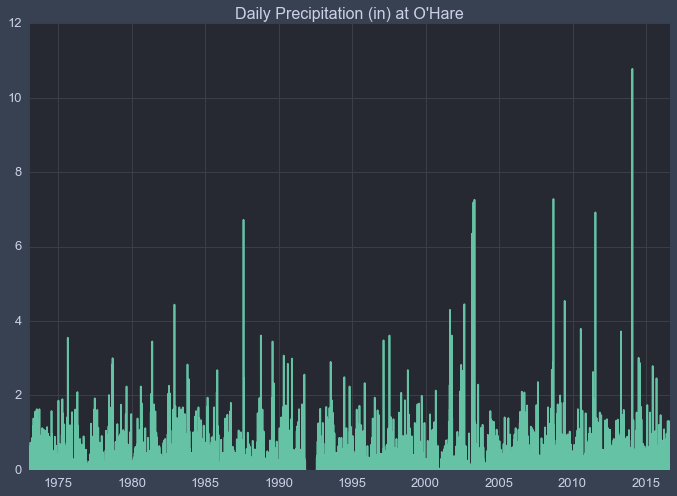

In [3]:
chi_rain_series = rain_df['HOURLYPrecip'].resample('1H').max().dropna()
# We take maximum, because when there are multiple reports within the same hour,
# the values are *accumulated* (and then reset at the next full hour). Thus we
# want to take the maximum reading from any given hour.
ax = chi_rain_series.resample('24H').sum().plot()
_ = ax.set_title('Daily Precipitation (in) at O\'Hare')

In [4]:
n_year_threshes = pd.read_csv('data/n_year_definitions.csv')
n_year_threshes = n_year_threshes.set_index('Duration')
n_year_threshes

,1-year,2-year,5-year,10-year,25-year,50-year,100-year
Duration,,,,,,,
10-day,4.12,4.95,6.04,6.89,8.18,9.38,11.14
5-day,3.25,3.93,4.91,5.70,6.93,8.04,9.96
72-hr,2.93,3.55,4.44,5.18,6.32,7.41,8.78
48-hr,2.70,3.30,4.09,4.81,5.88,6.84,8.16
24-hr,2.51,3.04,3.80,4.47,5.51,6.46,7.58
18-hr,2.30,2.79,3.50,4.11,5.06,5.95,6.97
12-hr,2.18,2.64,3.31,3.89,4.79,5.62,6.59
6-hr,1.88,2.28,2.85,3.35,4.13,4.85,5.68
3-hr,1.60,1.94,2.43,2.86,3.53,4.14,4.85


# Rainfall Equivalent

Verify that the precipitation amount is the "rainfall" equivalent, i.e. that snowfall has been melted into liquid water. We will verify this by plotting the total amount of precipitation reported each day from the ["Snowpocalypse" in 2011, where 21.2 inches of snow fell at O'Hare from 1/31/2011 to 2/2/2011](https://en.wikipedia.org/wiki/January_31_%E2%80%93_February_2,_2011_North_American_blizzard#Illinois). We see that each of these days has < 1 inch of precipitation reported, and the total number of inches reported is < 2.

Total of 1.62 inches of precip reported.


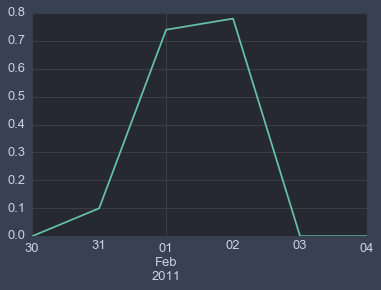

In [5]:
chi_rain_series['20110130':'20110204'].resample('24H').sum().plot(figsize=(6,4))
print('Total of {:.2f} inches of precip reported.'.format(
        chi_rain_series['20110130':'20110204'].sum()
    ))

# Plotting Rainfall vs. n-year storm threshold

In [6]:
dur_str_to_hours = {
    '5-min':5/60.0,
    '10-min':10/60.0,
    '15-min':15/60.0,
    '30-min':0.5,
    '1-hr':1.0,
    '2-hr':2.0,
    '3-hr':3.0,
    '6-hr':6.0,
    '12-hr':12.0,
    '18-hr':18.0,
    '24-hr':24.0,
    '48-hr':48.0,
    '72-hr':72.0,
    '5-day':5*24.0,
    '10-day':10*24.0
}

def plot_thresh(duration_str, n_years, ax=None):
    '''
    For a given duration and a given n, the number of years, plot the
    rolling amount of rain of the given duration, and the amount
    of rain in the given duration that constitutes an n-year storm.
    
    duration_str: duration as a string, see index of n_year_threshes
    n_years     : number of years, must be column of n_year_threshes
    ax          : optional, matplotlib axis object on which to plot
    
    >>> plot_thresh('48-hour', 100)
    >>> plot_thresh('5-day', 10)
    '''
    global rain_df
    global n_year_threshes
    global dur_str_to_hours
    
    if ax is None:
        ax = plt.gca()
    
    thresh = n_year_threshes.loc[duration_str, str(n_years) + '-year']
    
    duration = dur_str_to_hours[duration_str]
    duration = max(duration, 1) # cannot upsample to more frequent than hourly
    # TODO: want to throw warning?
    
    # Create plot
    rain_line = chi_rain_series.rolling(window=int(duration), min_periods=0).sum().plot(
        ax=ax, color=sns.color_palette()[0])
    
    x_limits = ax.get_xlim()
    
    ax.plot(x_limits, [thresh, thresh], color=sns.color_palette()[1])
    
    ax.set_ylim([0, ax.get_ylim()[1]])
    
    ax.legend(['moving cumulative rain', 
               str(n_years) + '-year ' + duration_str + ' threshold'],
              loc='best')
    
    return ax

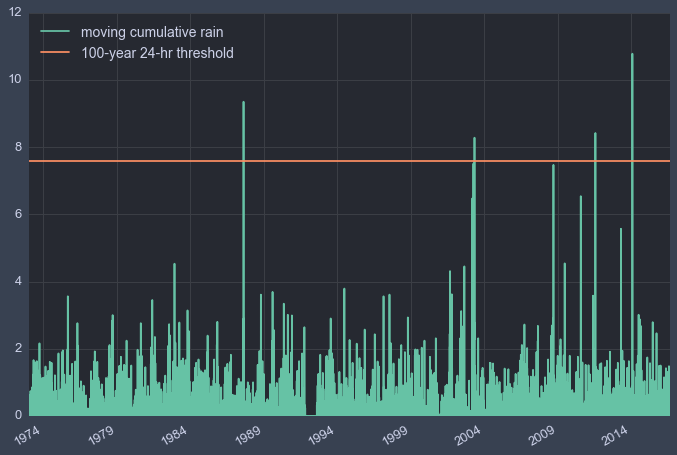

In [7]:
ax = plot_thresh('24-hr', 100)

# Calculate new n-year storm definitions

Essentially replicating [bulletin 70](http://www.isws.illinois.edu/atmos/statecli/RF/download.htm).

One of the pre-processing steps requires finding all of the "separate storm systems" for the durations that are less than or equal to 24 hours. Quoting from Bulletin 70, Section 3: Independence of Observations:

>     As in any statistical analysis, the individual ob-
    servations or data points should be independent of
    each  other.  With  a  partial-duration  series,  one  must
    be careful that the observations used are not meteor-
    ologically  dependent;  that  is,  they  must  be  from  sepa-
    rate storm systems. In the present study, data for
    precipitation  durations  of  24  hours  or  less  were  ob-
    tained  from  individual  precipitation  events,  defined
    as  precipitation  periods  in  which  there  was  no  pre-
    cipitation  for  at  least  6  hours  before  and  6  hours
    after  the  precipitation  event (Huff, 1967);  then,  only
    the maximum value for the particular duration (6
    hours,  12  hours,  etc.)  within  such  a  precipitation
    event  was  used.  This  ensures  that  the  precipitation
    values are independent of each other and are derived
    from  individual  storms.  For  precipitation  durations
    of 2 to 10 days, no time separation criteria were
    needed.

In [8]:
def get_independent_storms():
    '''
    TODO
    
    See page 21 of http://www.isws.illinois.edu/atmos/statecli/PDF/b70-all.pdf,
    Section 3: Independence of Observations, also quoted above.
    '''
    pass

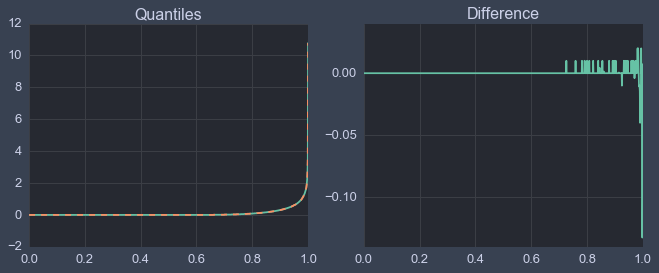

In [9]:
ps = np.linspace(0,1,1000)
f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(11,4))

ax1.set_title('Quantiles')
ax1.plot(chi_rain_series.rolling(window=int(24), min_periods=0).sum().quantile(ps))
ax1.hold(True)
ax1.plot(chi_rain_series.resample('24H').sum().dropna().quantile(ps), '--')

ax2.set_title('Difference')
junk = ax2.plot(ps, 
    chi_rain_series.rolling(window=int(24), min_periods=0).sum().quantile(ps) - 
         chi_rain_series.resample('24H').sum().dropna().quantile(ps)
)
# We hope that these will match well. One is generated using (somewhat) independent
# observations, and the other is generated using highly dependent observations.

In [10]:
def new_recurrence_intervals():
    '''
    TODO
    '''
    global rain_df
    global n_year_threshes
    global dur_str_to_hours
    
    new_recur_ints = n_year_threshes.ix[:-4,:].copy(deep=True)
    
    for recurrence in new_recur_ints.columns:
        for dur_str in new_recur_ints.index:
            thresh = n_year_threshes.ix[dur_str, recurrence]
            dur = dur_str_to_hours[dur_str]
            rain = chi_rain_series.rolling(window=int(dur), min_periods=0).sum()
            # 24 * 365.25 = 8766 hours per year
            # rain.size * dur is the number of total hours we are looking at, so
            # rain.size * dur / 8766 is total number of years in dataset
            new_recur_ints.ix[dur_str, recurrence] = rain.size * dur / 8766. / sum(rain > thresh)
    
    return new_recur_ints

In [12]:
new_recur_ints = new_recurrence_intervals()

In [16]:
print(new_recur_ints.to_string())

            1-year    2-year    5-year   10-year   25-year    50-year   100-year
Duration                                                                        
10-day    1.367616  2.363959  3.639560  6.122948  7.972638  11.844276  26.527516
5-day     1.181166  2.177883  3.952641  4.574523  7.279120   9.619324  26.256827
72-hr     1.088788  1.984449  3.557377  4.839816  5.603998   8.529842  13.425230
48-hr     1.008591  1.940184  3.330963  4.960326  5.518861   8.168791  12.475971
24-hr     1.150020  2.042198  3.586298  4.901274  5.624413   7.299770  19.793608
18-hr     1.054577  1.778688  3.051189  4.084395  5.676108   5.984114  13.309495
12-hr     1.146178  1.709747  2.875049  4.361303  5.848112   6.200407  16.082307
6-hr      1.025167  1.726959  2.859077  4.084395  6.276022   8.577230   8.872997
3-hr      1.063293  1.608231  3.063297  4.765128  7.568144   8.041153   9.189890
2-hr      1.128583  1.715446  3.298935  5.360769  7.147692   8.577230   9.530256
1-hr      0.875228  1.786923